# ISEL - CPS 
## Semestre 2022/23
# <br>
###  <center> Trabalho Prático 1 </center>
# </br>


Trabalho realizado por:
* Bárbara Jesus, numero <b> 45108 </b>
* João Fernandes, numero <b> 47478 </b>
* Duarte Afonso, numero <b> 47736 </b>

<b> Turma L33D - Docente Michele Mengucci</b>

A figura representa o esquema típico do processo de envio e recepção de informação usando modulações
digitais.

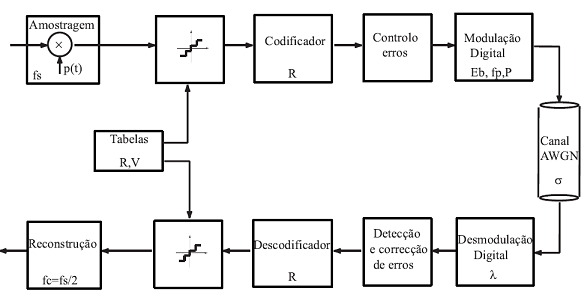


O 2º trabalho (parte-A) foca o desenvolvimento dos blocos Modulação e desmodulação Digital e com estes é terminado o desenvolvimento de todo o sistema de transmissão digital.



Considere as funções criadas nos trabalhos anteriores.

Construa uma função que simule a modulação digital 16-PSK.
Esta função recebe como parâmetro de entrada um array de bits e retorna um array, simulando o sinal analógico modulado a transmitir. Dado que o sinal modulado é simulado (um sinal discreto), é necessário que a função ainda receba como parâmetros de entrada o número de pontos por cada símbolo ($P=8$), simulando a amostragem. Esta função recebe ainda a energia média por bit ($E_b$). Admita que a frequência da portadora é tal que cada simbolo contém um período da portadora.


In [1]:
import numpy as np

# Número de simbolos a transmitir
n_symb = 10000
# Número de bits por simbolo
bits_symb = 4
# Bits a transmitir
bits = np.random.randint(0, 2, n_symb * bits_symb)
print(bits)

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Código de Gray com 4 bits
codGray16 = np.array([[0,0,0,0],
                      [0,0,0,1],
                      [0,0,1,1],
                      [0,0,1,0],
                      [0,1,1,0],
                      [0,1,1,1],
                      [0,1,0,1],
                      [0,1,0,0],
                      [1,1,0,0],
                      [1,1,0,1],
                      [1,1,1,1],
                      [1,1,1,0],
                      [1,0,1,0],
                      [1,0,1,1],
                      [1,0,0,1],
                      [1,0,0,0]])

# Frequência de amostragem
Fs = 48000

# Número de períodos da portadora por simbolo
N = 1

def mod_MPSK(bits, Eb, P=8):

    # Número de simbolos a transmitir
    M = 16
    # Bits por simbolo
    k = int(np.log2(M))
    
    # Frequência da portadora
    fc = N * Fs / P
    # Amplitude da portadora
    A = np.sqrt(2 * Eb / P)
    
    # Tempo discreto
    n = np.arange(0, P)
    
    carrier = A * np.cos(2 * np.pi * fc * (n / Fs))
    
    # Fase do primeiro simbolo
    first_symbol_phase = 0
    # Fase entre simbolos
    phase_between_symbols = 2 * np.pi / M
    
    cos_symbols = np.zeros(M * P)

    sinal = np.zeros(int((len(bits)//k) * P))
    
    phase = np.arange(0, 2 * np.pi, phase_between_symbols)
    
    # Sinal modulado
    for i in range(int(len(bits)//k)):
        for index in range(len(codGray16)):
            if np.array_equal(bits[i*k:i*k+k], codGray16[index]):
                sinal[i*P:(i+1)*P] = A * np.cos(2 * np.pi * fc * (n / Fs) + phase[index])

    return sinal

Construa uma função que simule, no receptor, um filtro adaptado (desmodulação).
Este deve receber um array com o sinal modulado com ruído e deve retornar um array com a sequência binária correspondente.


In [3]:
#resposta
def receptor(sinal, P=8):

    M = 16
    k = int(np.log2(M))
    phase_between_symbols = 2 * np.pi / M
    
    # Tempo discreto
    n = np.arange(0, P)
    
    # Frequência da portadora
    fc = N * Fs / P
    
    # Regiões de decisão
    reg_decisao = np.arange(0 + phase_between_symbols / 2, 2 * np.pi, phase_between_symbols)
    
    bitsEstimados = np.zeros((len(sinal)//P) * k)
    
    compIQ = np.array([np.zeros(len(sinal)//P), np.zeros(len(sinal)//P)])
    
    # Para cada simbolo
    for i in range(len(sinal) // P):
        
        # Componente em fase do sinal
        SI = np.sum(np.cos(2 * np.pi * fc * (n / Fs)) * sinal[i*P:i*P+P])
        
        # Componente em quadratura do sinal
        SQ = np.sum(-np.sin(2 * np.pi * (fc / Fs) * n) * sinal[i*P:i*P+P])
        
        # Fase do sinal
        phase = np.arctan(SQ/SI)
        if SI < 0:
            phase += np.pi
        if phase < 0:
            phase += 2 * np.pi
        
        # Amplitude do sinal
        A = np.sqrt(SI**2 + SQ**2)
        
        index = len(reg_decisao[phase > reg_decisao])
        if index > 15:
            index = 0
        
        bitsEstimados[i*k:(i+1)*k] = codGray16[index]
        
        compIQ[0][i] = SI
        compIQ[1][i] = SQ

    return bitsEstimados, compIQ

In [12]:
# Energia médio de bit
Eb = 4

# Sinal modulado
sinal = mod_MPSK(bits, Eb)

bits_out, compIQ = receptor(sinal)

BER = len(bits[bits != bits_out]) / len(bits)
print("BER =", BER)

[-7.07106781e-01 -1.00000000e+00 -7.07106781e-01 ... -7.07106781e-01
 -1.83697020e-16  7.07106781e-01]
BER = 0.0


Considere que o canal segue o modelo de canal AWGN. 

Este pode ser implementado a partir da linha de código em baixo.  Recebe o sinal modulado (sinal_in), adiciona ruído, com uma determinada potência ${\sigma_n}^2$ (pot_noise) e devolve o sinal com ruído num array (sinal_out).

In [5]:
#CANAL AWGN

# Sinal modulado
sinal_in = sinal
# Potência do ruído
pot_noise = 1 * 10 ** -3

# Sinal com ruído
sinal_out = sinal_in + np.sqrt(pot_noise) * np.random.randn(len(sinal_in))

In [6]:
bits_out, compIQ = receptor(sinal_out)

BERp = len(bits[bits != bits_out]) / len(bits)
print("Bits errados:", len(bits[bits != bits_out]), "/", len(bits))
print("BER =", BERp)

Bits errados: 0 / 40000
BER = 0.0


Construa uma função que calcule o BER teórico para a modulação implementada.

In [7]:
# BER teórico para Modulação 16-PSK
def BER_teorico(Eb, pot_noise, M = 16, P = 8):
    A = np.sqrt(2 * Eb / P)
    St = (A ** 2) / 2
    N0 = Eb * pot_noise / (2 * St)
    k = int(np.log2(M))
    
    BER_t = (1 / k) * math.erfc(np.sqrt(k * (np.sin(np.pi / M) ** 2) * (Eb / N0)))
    return BER_t

BERt = BER_teorico(Eb, pot_noise)
print(BERt)

8.695339775815616e-69


Avalie todo o sistema de emissão e receção. Para isso deve medir experimentalmente e comparar, sempre que possível, com os valores teóricos, os seguintes índices:

    A SNR no canal e SNR na recepção;
    
    BER antes e depois da correcção de erros;
    
    Apresente a constelação antes e depois do sinal passar pelo canal.

Para o efeito deve atribuir diferentes valores aos parâmetros do sistema e avalia-lo com e sem o modulo de correcção de erros.



In [8]:
def Measure_SNRp(x,xq):
    
    erro = x-xq
    
    SNRpdb = 10 * np.log10(np.sum(x**2)/np.sum(erro**2))

    return SNRpdb

def Measure_SNRt(R,Vmax,P):
    
    SNRtdb = 6.02 * R + 10*np.log10((3*P)/Vmax)

    return SNRtdb

G=np.array([[1,0,0,0,0,1,1],
            [0,1,0,0,1,1,0],
            [0,0,1,0,1,0,1],
            [0,0,0,1,1,1,1]])

def Hamming_7_4(msg):
    
    palavra = np.dot(msg, G) % 2
    
    return palavra

Ht = np.vstack((G[:, 4:], np.eye(3)))

def Detetor(palavra):

    sindroma = np.dot(palavra, Ht) % 2
    for i in range(len(Ht)):
        if np.array_equal(sindroma, Ht[i]):
            palavra[i] = (palavra[i] + 1) % 2
            break

    msg = palavra[:4]

    return msg

SNR prático no canal: 27.002493609156623
SNR teórico no canal: 25.386140942973967
BER teórico antes da correção de erros: 8.695339775815616e-69
BER prático antes da correção de erros: 0.0


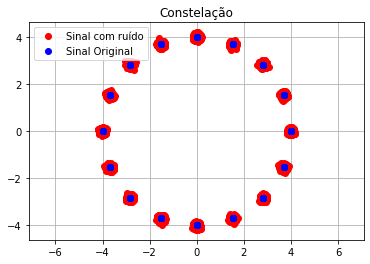

In [9]:
# SNR após passar o canal (receção)

print("SNR prático no canal:", Measure_SNRp(sinal_in, sinal_out))
print("SNR teórico no canal:", Measure_SNRt(4, np.max(sinal_out), np.sum(sinal_out**2 / len(sinal_out))))

# BER antes da correção de erros
print("BER teórico antes da correção de erros:", BERt)
print("BER prático antes da correção de erros:", BERp)

# Correção de erros


# Constelação antes do canal

bits_out, compIQ = receptor(sinal_in)
bits_out_rec, compIQ_rec = receptor(sinal_out)

# Plot da constelação do sinal original (azul) e do sinal com ruído após passar o canal (vermelho)
plt.axis('equal')
plt.title('Constelação')
plt.plot(compIQ_rec[0], compIQ_rec[1], 'ro', label='Sinal com ruído')
plt.plot(compIQ[0], compIQ[1], 'bo', label='Sinal Original')
plt.grid()
plt.legend()